# Two Identical Sector Hank (Two Formal Sector)
The purpose of this is to introduce the new consumer type `TwoSectorModel_HANK`


In [1]:
from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time
from copy import copy, deepcopy

from scipy import optimize

In [2]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

### 1) Prepare the Agent in HARK

In [3]:
# Defining microeconomic parameters
cycles = 0          # 0 means infinite horizon
T_cycles = 1        # Number of cycles to simulate
T = 300             # Dimention of TxT Jacobian matrix

# Parameters which are the same for all agents (Could be different for different agents)
LivPrb = .99375     # Probability of surviving 
PermShkStd = 0.06   # Standard deviation of log permanent income shocks
TranShkStd = 0.2    # Standard deviation of log transitory income shocks
PermGroFac = 1.0    # Permanent income growth factor
BoroCnstArt = 0.0   # Artificial borrowing constraint; imposed minimum level of end-of period assets
UnempPrb = 0.05     # Probability of unemployment
IncUnemp = 0.7      # Unemployment benefits replacement rate

In [4]:
### Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

## Size of the formal sector (sf); the relative size (sf_share) and wage share (wage_share) which is the ratio between wages in the sectors.
sf = 0.5
sf_share = 1.0
wage_share = 1.0

print("Relative Size of Formal Sector: ", sf_share)
print("Size Formal Sector: ", sf)

Relative Size of Formal Sector:  1.0
Size Formal Sector:  0.5


In [5]:
# Defining aggregate steady state values of the economy
r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B + (UnempPrb * IncUnemp)  
    return T

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Zf_ss = Y_ss- T_ss 
C_ss = Y_ss - G_ss

print('Zf_ss: ' +str(Zf_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.24250000000000002
Zf_ss: 0.7575
C_ss: 0.8


In [6]:
T_cycles = 500
cycles = 1

init_twosector_life = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.9455718034241029,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd, PermShkStd])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd, TranShkStd])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp, IncUnemp])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0, 0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zf_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1, 1])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt, BoroCnstArt],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb, LivPrb])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac, PermGroFac])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [sf, 1 - sf],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector_life['TranShkMean_Func'] = [function]

In [7]:
cycles = 0
T_cycles = 1
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.9455718034241029,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd, PermShkStd])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd, TranShkStd])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp, IncUnemp])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0, 0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zf_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1, 1])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt, BoroCnstArt],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb, LivPrb])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac, PermGroFac])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [sf, 1 - sf],

}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector['TranShkMean_Func'] = [function]

### Calibrating Discount Factor to assumer household assets equal government bonds

In [8]:
### Target Steady State Asset
def ss_func(beta):
    init_twosector_life['DiscFac'] = beta
    init_twosector['DiscFac'] = beta
    Agent_func_life = TwoSectorMarkovConsumerType(**init_twosector_life, verbose = False)
    Agent_func_life.solve()
    Agent_func = TwoSectorMarkovConsumerType(**init_twosector, verbose = False)
    Agent_func.solution_terminal = deepcopy(Agent_func_life.solution[0])
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):  
    difference =   ss_func(beta) - Asset_target 
    return difference

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.95)
print(DiscFac)

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered


0.9455479079487203


### Initiate Agent type with calibrated Discount Factor

In [9]:
init_twosector_life['DiscFac'] = DiscFac
init_twosector['DiscFac'] = DiscFac
Agent_GE_life = TwoSectorMarkovConsumerType(**init_twosector_life)
Agent_GE_life.solve()
Agent_GE = TwoSectorMarkovConsumerType(**init_twosector)
Agent_GE.solution_terminal = deepcopy(Agent_GE_life.solution[0])
Agent_GE.solve()

In [10]:
A_ss, C_ss, A_ss_Markv, C_ss_Markv = Agent_GE.compute_steady_state()
print(A_ss, C_ss)

0.2499999999994525 0.7649062499999417


In [11]:
print(A_ss_Markv, C_ss_Markv)

[0.25 0.25] [0.76490625 0.76490625]


Saving and Consumption is the same for both identical sectors

In [12]:
### Plot Consumption Functions
mGrid = np.linspace(0, 4, 200)
mGrid = mGrid - 2

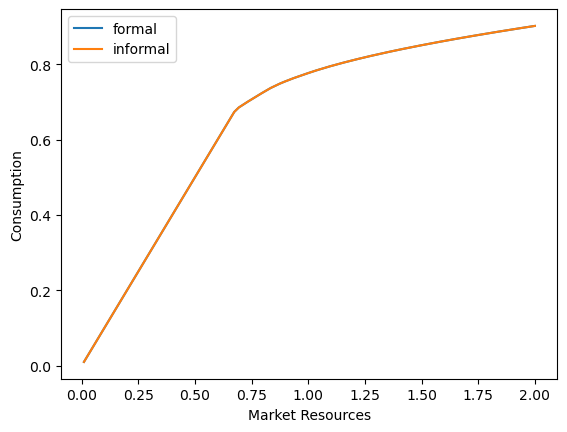

In [13]:
plt.plot(mGrid, Agent_GE.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, Agent_GE.solution[0].cFunc[1](mGrid), label = 'informal')
plt.ylabel("Consumption")
plt.xlabel("Market Resources")
plt.legend()

#### Calculate Jacobians

In [14]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',0,T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor',0, T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 14.062010526657104


Let's plot them

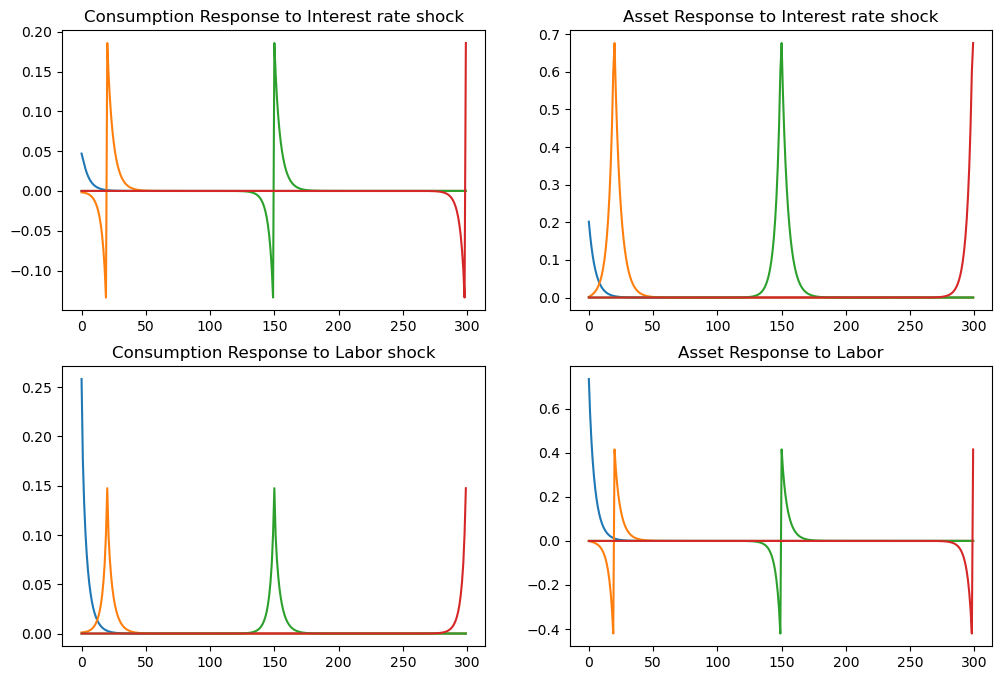

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

From this exercise, we can already see the MPC which is the consumption response to a labor shock happening today without anticipation. THis is in the bottom left graph the starting point of the first blue line. The resulting Keynesian Multiplier can be calculated using:
$$
    Multiplier = \frac{1}{1-MPC} 
$$

In [16]:
Multiplier = 1/(1 - CJACZ.T[0][0])
print("MPC in the model is: ", CJACZ.T[0][0])
print("Keynesian Multiplier is: ", Multiplier)

MPC in the model is:  0.2583169238246086
Keynesian Multiplier is:  1.348284775697811


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


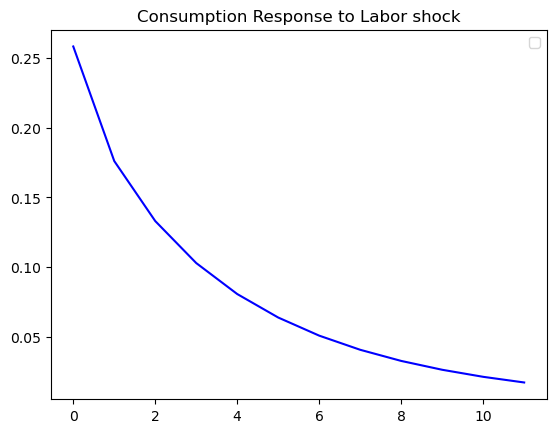

In [17]:
### Plot i-MPC
plt.plot(CJACZ.T[0][:12], color = 'blue')
plt.legend()
plt.title("Consumption Response to Labor shock")
plt.show()

### Switch from HARK to SSJ
We're done with the HARK-work and can define dictionaries for Steady State Values and Jacobians

In [18]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACZ, 'r': CJACR} ,'A' : {'Z' : AJACZ, 'r': AJACR}}) 

In [19]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B # total tax burden
    Z = Y - T

    deficit = G - T
    
    return T, Z, deficit


@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [20]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [21]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [22]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

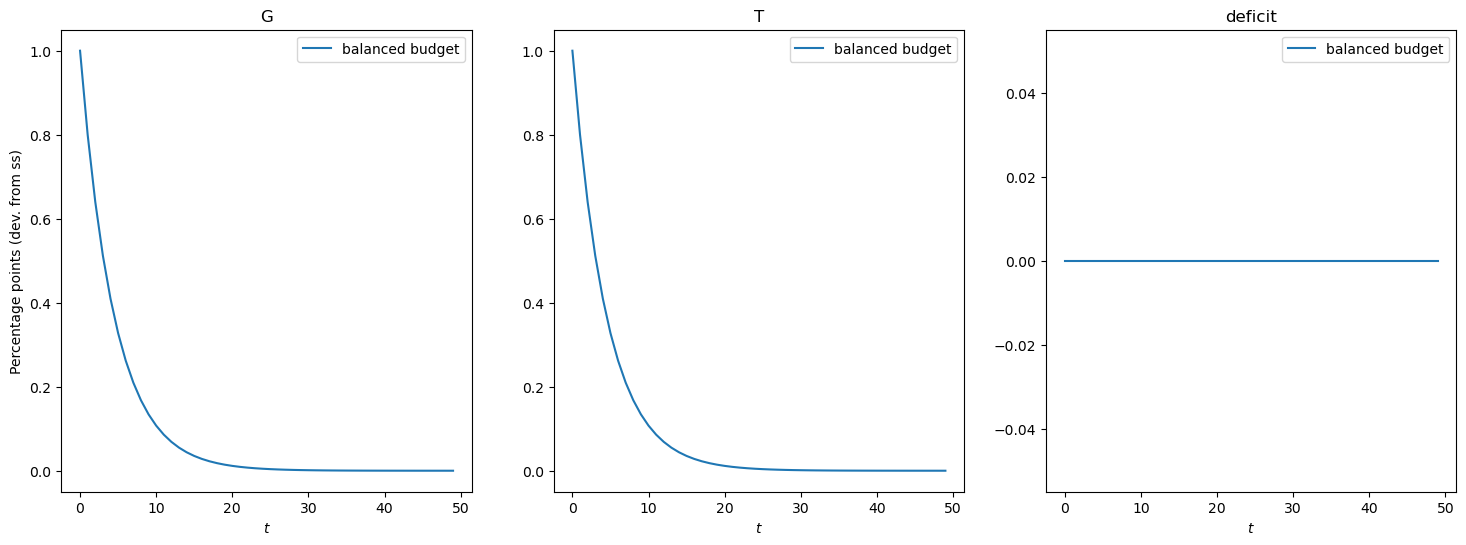

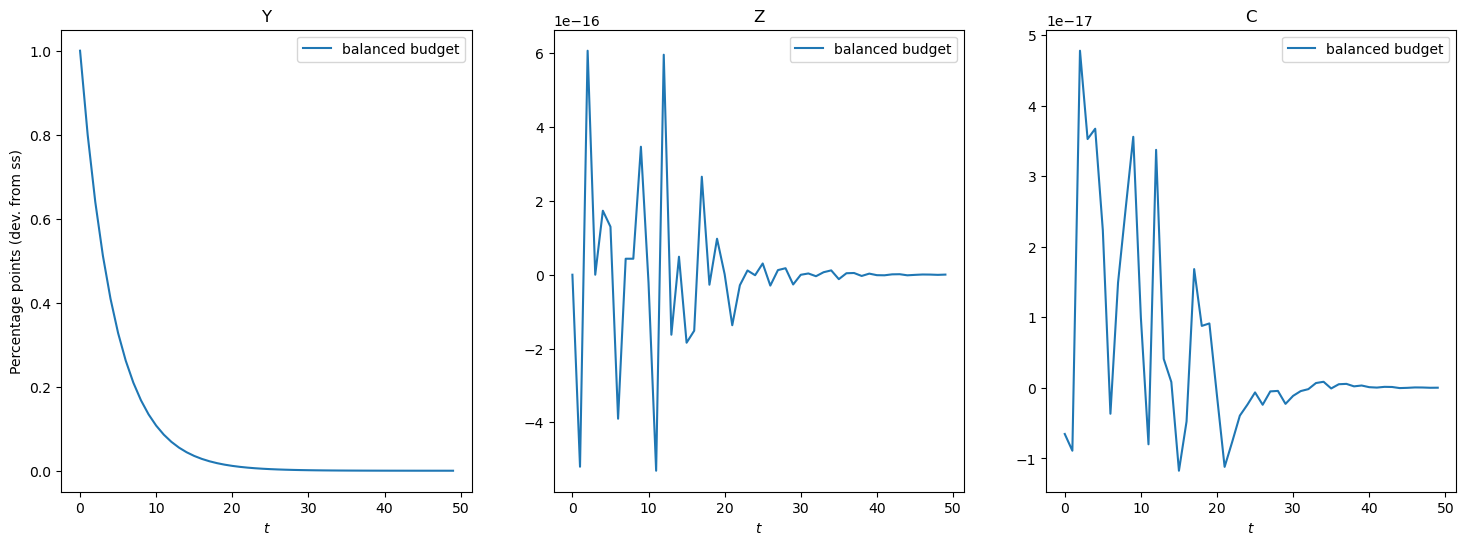

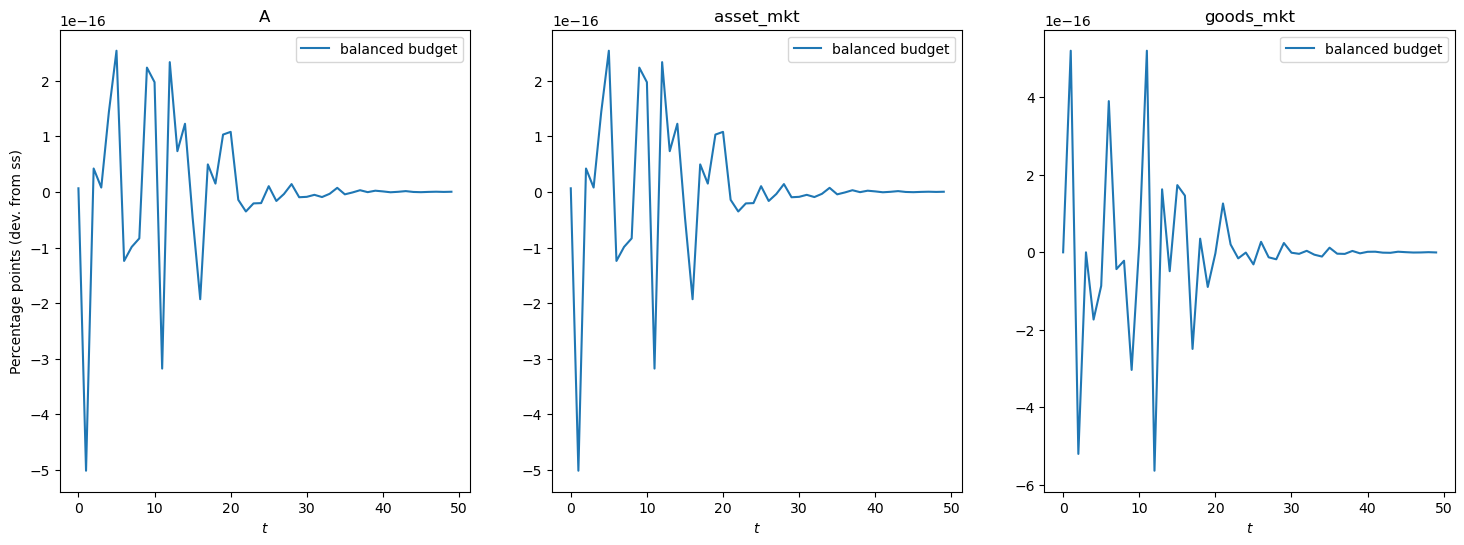

In [23]:
# Plot them
show_irfs([irfs_G], ['G', 'T', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Z', 'C'], labels=["balanced budget"])
show_irfs([irfs_G], ['A','asset_mkt', 'goods_mkt'], labels=["balanced budget"])

In [24]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

In [25]:
HARK_SteadyState_Dict

<SteadyStateDict: ['C', 'r', 'Y', 'B', 'G', 'A']>

In [26]:
print(C_ss, r_ss, Y_ss, B_ss)

0.7649062499999417 0.030000000000000027 1.0 0.25


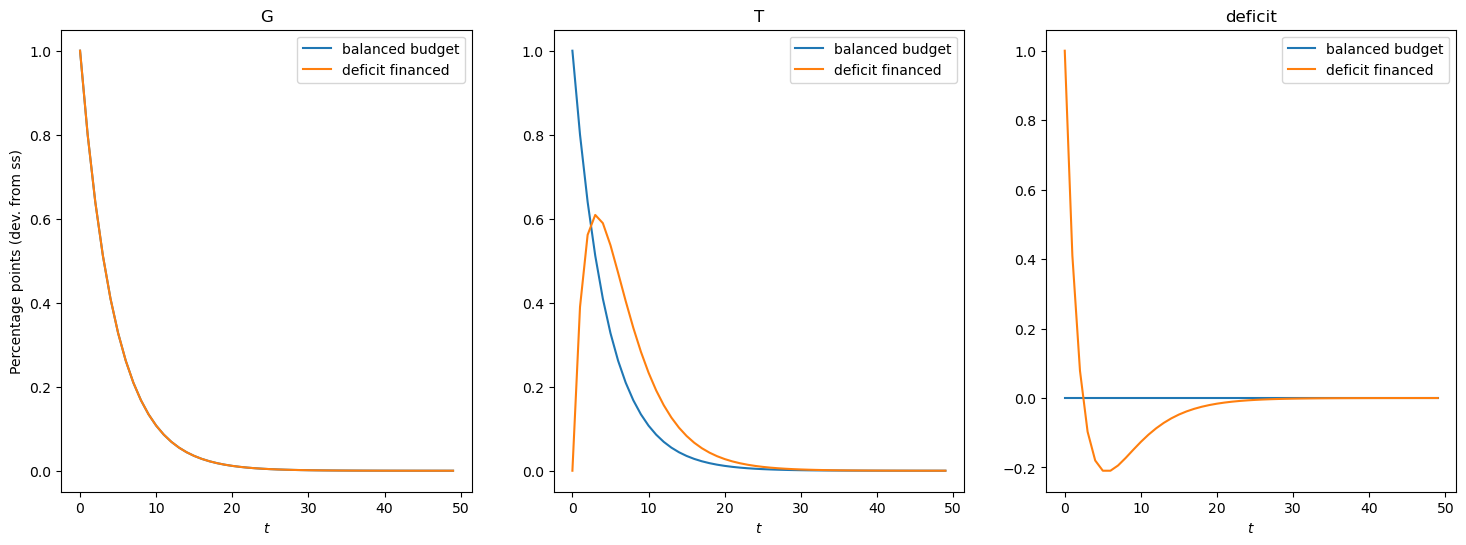

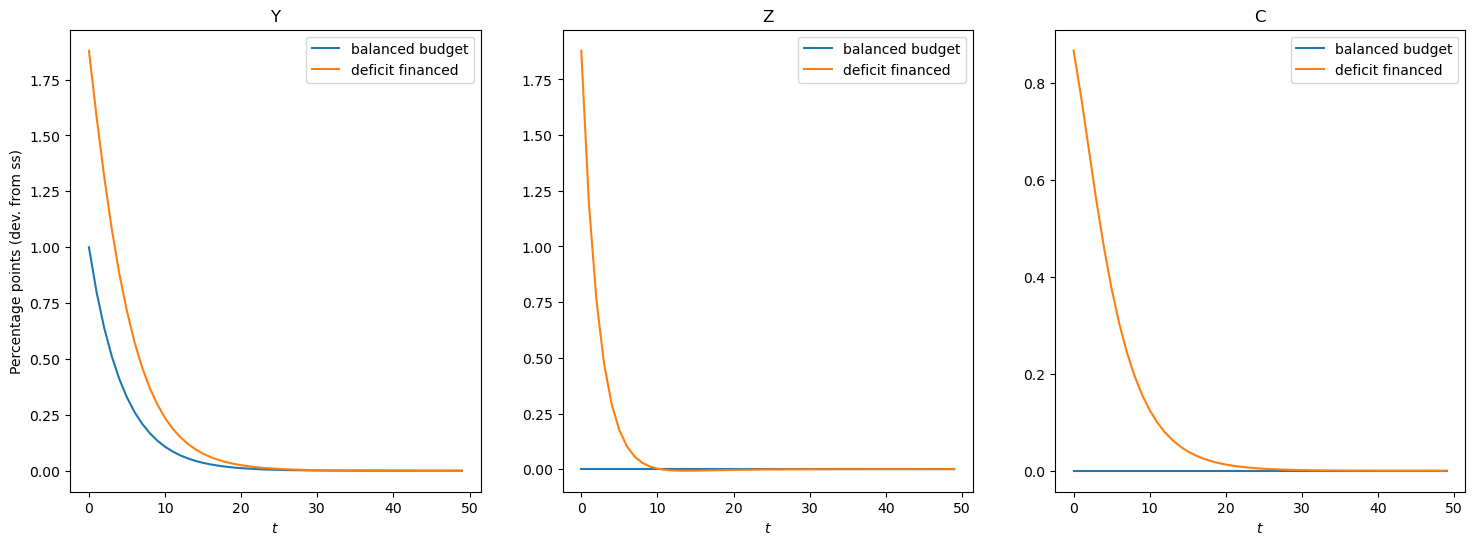

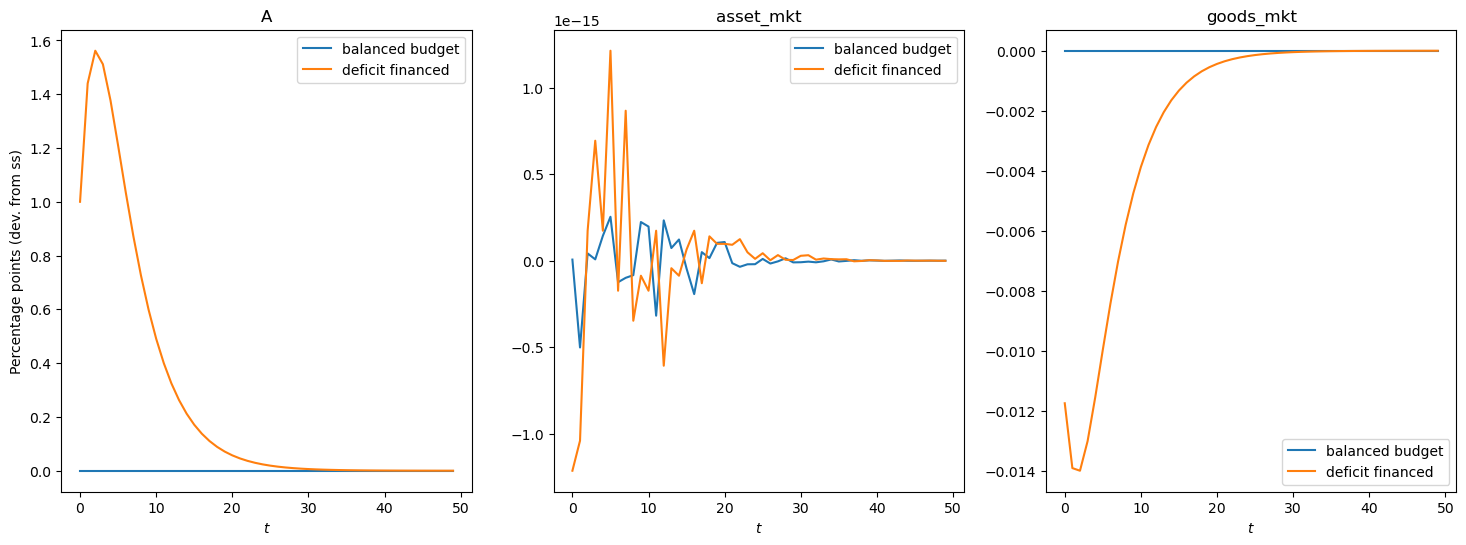

In [27]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Z', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])